<a href="https://colab.research.google.com/github/nsoria1/covid19-chestxray-analysis/blob/master/covid19_chestrayx_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalación de dependencias & bajada de datasets

Instalar libreria de procesamiento de imagenes

In [28]:
!pip install imutils

Crear carpetas donde alojar los key para la API de Kaggle

In [0]:
!if [ -d "/root/.kaggle" ]; then rm -Rf /root/.kaggle; fi

In [0]:
!mkdir /root/.kaggle
!echo '{"username":"nicolassoria","key":"4e554baab00edaf0d56fb1d4990269ed"}' > /root/.kaggle/kaggle.json

Borrar los archivos de Kaggle si existieran

In [0]:
![ -e chest-xray-pneumonia.zip ] && rm chest-xray-pneumonia.zip && [ -e covid-chest-xray.zip ] && rm covid-chest-xray.zip

Descargar datasets Rayos X normales y de Neumonia y Rayos X de Covid 19

In [32]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d bachrr/covid-chest-xray

 99% 2.28G/2.29G [00:19<00:00, 70.7MB/s]
100% 2.29G/2.29G [00:19<00:00, 125MB/s] 
 95% 200M/211M [00:01<00:00, 154MB/s]
100% 211M/211M [00:01<00:00, 128MB/s]


Crear directorios para alojar data

In [33]:
!!if [ -d "chest-xray-pneumonia" ]; then rm -Rf chest-xray-pneumonia; fi

[]

In [34]:
!!if [ -d "covid-chest-xray" ]; then rm -Rf covid-chest-xray; fi

[]

In [0]:
!mkdir chest-xray-pneumonia && mkdir covid-chest-xray

Descomprimir archivos en carpetas creadas

In [0]:
!unzip -qq chest-xray-pneumonia.zip -d chest-xray-pneumonia/ && rm chest-xray-pneumonia.zip && unzip -qq covid-chest-xray.zip -d covid-chest-xray/ && rm covid-chest-xray.zip

Validar carpetas creadas y archivos borrados

In [19]:
!ls -l

total 12
drwxr-xr-x 3 root root 4096 May  7 01:08 chest-xray-pneumonia
drwxr-xr-x 4 root root 4096 May  7 01:08 covid-chest-xray
drwxr-xr-x 1 root root 4096 May  4 16:26 sample_data


### Importar librerias requeridas para procesamiento

In [0]:
# Standart libraries
import shutil
import cv2
import os
import random
# Import data handling libraries
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Import scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Import Tensorflow / Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Definir área de trabajo

In [38]:
!!if [ -d "dataset" ]; then rm -Rf dataset; fi

[]

In [0]:
!mkdir -p dataset/covid
!mkdir -p dataset/normal

In [0]:
dataset_path = '/content/dataset'
covid_dataset_path = '/content/covid-chest-xray'
pneumonia_dataset_path ='/content/chest-xray-pneumonia/chest_xray'

### Construcción de set de datos


Construir set de datos de rayos X con Covid 19

In [0]:
samples = 50

Recorrer el archivo *metadata.csv*, cuyo campo *finding* menciona si tiene COVID-19 o no, y en caso positivo mover a carpeta dataset/covid

In [0]:
# Use the dataset variable to open the metadata file
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if the current case is not COVID-19 or if it is not a 'PA', skip the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist, due the errors in the metadeta file, ignore the row
    if not os.path.exists(imagePath):
        continue

    # use the filename to construct the path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

Construir set de datos de rayos X normales

In [0]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# set seed and shuffle x ray images
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # use the filename and construct the path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Realizar plots de los rayos X

Función de apoyo para realizar un plot de los rayos X

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    # Plot the images in a grid
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    # Loop through list of images
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

Plot de los rayos X

In [0]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

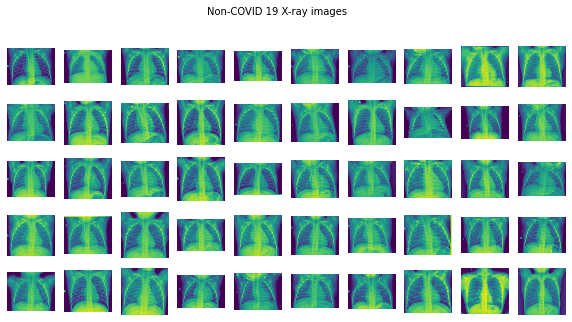

In [46]:
# Call auxiliar function defined before
plots_from_files(normal_images, rows=5, maintitle="Non-COVID 19 X-ray images")

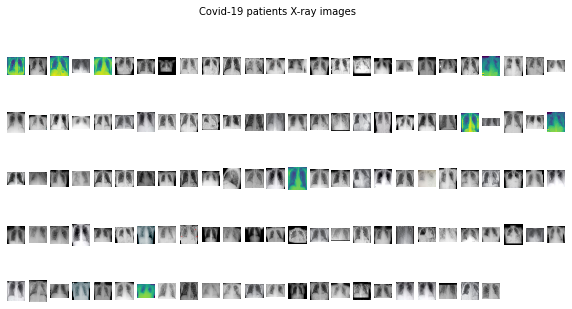

In [48]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 patients X-ray images")

### Pre-procesamiento de datos

In [0]:
# Set learning rate, epochs number, and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 8



*   Cargar en una lista los path de las imagenes
*   Se recorre la lista 





In [0]:
# pick the list of images in our dataset directory, then set the list of data
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the feature label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and re-size it to 224x224 pixels
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update data and labels list
    data.append(image)
    labels.append(label)
# turn into numpy array
data = np.array(data) / 255.0
labels = np.array(labels)

In [0]:
# instanciate a binarizer to one-hot encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# split data into training and testing splits using 75% for training
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

Quote: "*In order to ensure that our model generalizes, we perform data augmentation by setting the random image rotation setting to 15 degrees clockwise or counterclockwise.*" 

### Creación de Modelo

In [62]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


### Entrenamiento de modelo

In [63]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
16/16 [==============================] - 83s 5s/step - loss: 0.6243 - accuracy: 0.6562 - val_loss: 0.5409 - val_accuracy: 0.7111
Epoch 2/10
16/16 [==============================] - 82s 5s/step - loss: 0.4938 - accuracy: 0.8065 - val_loss: 0.4739 - val_accuracy: 0.7333
Epoch 3/10
16/16 [==============================] - 81s 5s/step - loss: 0.4448 - accuracy: 0.7984 - val_loss: 0.4197 - val_accuracy: 0.7556
Epoch 4/10
16/16 [==============================] - 80s 5s/step - loss: 0.4192 - accuracy: 0.8306 - val_loss: 0.3685 - val_accuracy: 0.9111
Epoch 5/10
16/16 [==============================] - 80s 5s/step - loss: 0.3403 - accuracy: 0.8871 - val_loss: 0.3429 - val_accuracy: 0.8000
Epoch 6/10
16/16 [==============================] - 80s 5s/step - loss: 0.3168 - accuracy: 0.8871 - val_loss: 0.2929 - val_accuracy: 0.9333
Epoch 7/10
16/16 [================

### Ploteo de métricas de entrenamiento

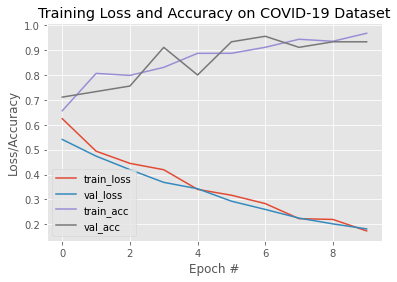

In [64]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Evaluación de modelo

In [65]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.94      0.97      0.95        32
      normal       0.92      0.85      0.88        13

    accuracy                           0.93        45
   macro avg       0.93      0.91      0.92        45
weighted avg       0.93      0.93      0.93        45



In [66]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[31  1]
 [ 2 11]]
acc: 0.9333
sensitivity: 0.9688
specificity: 0.8462


### Guardado de modelo

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('covid_model.h5') 

### Prueba de modelo guardado

In [68]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('covid_model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Prueba en paciente con COVID-19

[[9.9999964e-01 3.3951733e-07]]
[0]


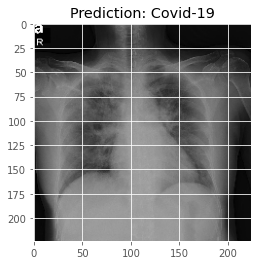

In [70]:
import numpy as np
from tensorflow.keras.preprocessing import image


#test_image = cv2.imread('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg')
#test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#test_image = cv2.resize(test_image, (224, 224))
#test_image = np.expand_dims(test_image, axis = 0)

img_width, img_height = 224, 224
img = image.load_img('../content/covid-chest-xray/images/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1))
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)
plt.savefig('plot_out.png')

Prueba en paciente sin COVID-19

[[2.7271928e-23 1.0000000e+00]]
1


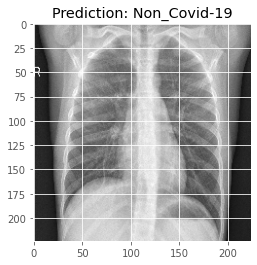

In [72]:
img_width, img_height = 224, 224
img = image.load_img('/content/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0003-0001.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1)[0])
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)

### Descargar el modelo generado

In [73]:
!ls -l

total 58052
drwxr-xr-x 3 root root     4096 May  7 03:06 chest-xray-pneumonia
drwxr-xr-x 4 root root     4096 May  7 03:06 covid-chest-xray
-rw-r--r-- 1 root root 59344384 May  7 03:51 covid_model.h5
drwxr-xr-x 4 root root     4096 May  7 03:10 dataset
-rw-r--r-- 1 root root    47469 May  7 03:53 plot_out.png
-rw-r--r-- 1 root root    29165 May  7 03:48 plot.png
drwxr-xr-x 1 root root     4096 May  4 16:26 sample_data


In [76]:
from google.colab import drive
drive.mount('/content/gdrive')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 40090, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [81]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp covid_model.h5 "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
